In [1]:
# Plot graph in notebook
import matplotlib.pyplot as plt
# Processing
from cmath import exp, pi # cmath for complex number 
import numpy as np
import pyaudio
# Performance
import time
# Checking fft and stft
import scipy.signal as signal
from scipy.fftpack import fft

# Spectrum analyzer

## 1. Generate test signal and plot wave form

In [3]:
def rect_func(x, t1, t2):
    # t2 > t1
    res = []
    N = len(x)
    for i in x:
        if t1 <= i <= t2:
            res.append(1)
        else:
            res.append(0)
    return np.array(res)

Text(0, 0.5, 'Amplitude')

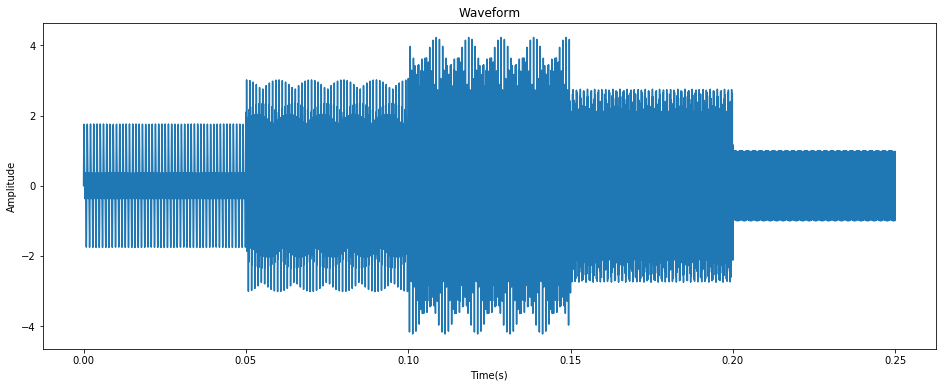

In [4]:
# Generate signal 
fs = 44100                            
t = np.arange(0, 0.25, 1/fs)       
# Signal
x = np.sin(2*pi*1000*t) *rect_func(t, 0   , 0.1 ) + \
    np.sin(2*pi*2000*t) *rect_func(t, 0   , 0.15) + \
    np.sin(2*pi*5000*t) *rect_func(t, 0.05, 0.15) + \
    np.sin(2*pi*10000*t)*rect_func(t, 0.05, 0.2 ) + \
    np.sin(2*pi*15000*t)*rect_func(t, 0.1 , 0.2 ) + \
    np.sin(2*pi*20000*t)*rect_func(t, 0.1  ,0.25)
# Plot signal in time domains
plt.figure(figsize = (16, 6))
plt.plot(t, x)
plt.title("Waveform")
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')

## 2. FFT and Spectrum

### a. Cooley–Tukey FFT algorithm

The discrete Fourier transform (DFT) is defined by the formula:

$$X_k=\sum\limits_{n=0}^{N-1}x_n e^{\frac{-2\pi i}{N}nk}$$

where $k$ is an integer ranging from $0$ to $N-1$

$$X_k = \sum\limits_{m=0}^{N/2-1}x_{2m}e^{\frac{-2\pi i}{N}(2m)k} + \sum\limits_{m=0}^{N/2-1}x_{2m+1}e^{\frac{-2\pi i}{N}(2m+1)k}$$

\begin{align*}
X_k = \sum\limits_{m=0}^{N/2-1}x_{2m}e^{\frac{-2\pi i}{N/2}mk} + e^{\frac{-2\pi i}{N}k}\sum\limits_{m=0}^{N/2-1}x_{2m+1}e^{\frac{-2\pi i}{N/2}mk} = DFT(x_{2m}) + e^{\frac{-2\pi i}{N}k}DFT(x_{2m+1})
\end{align*}

where $m$ in an integer ranging from $0$ to $N/2-1$

- DFT of even-indexed part of $x_n = DFT(x_{2m}) = E_k$ 

- DFT of odd-indexed part of $x_n = DFT(x_{2m+1}) = O_k$

$$X_k = E_k + e^{\frac{-2\pi i}{N}k}O_k$$

\begin{align*}
X_{k+\frac{N}{2}} &=\sum\limits_{m=0}^{\frac{N}{2}-1}x_{2m}e^{\frac{-2\pi i}{N/2}m(k+\frac{N}{2})} + e^{\frac{-2\pi i}{N}(k+\frac{N}{2})}\sum\limits_{m=0}^{\frac{N}{2}-1}x_{2m+1}e^{\frac{-2\pi i}{N/2}m(k+\frac{N}{2})} 
\\  &= \sum\limits_{m=0}^{\frac{N}{2}-1}x_{2m}e^{\frac{-2\pi i}{N/2}mk}e^{-2\pi mi} + e^{\frac{-2\pi i}{N}k}e^{-\pi i}\sum\limits_{m=0}^{\frac{N}{2}-1}x_{2m+1}e^{\frac{-2\pi i}{N/2}mk}e^{-2\pi mi} 
\\  &= \sum\limits_{m=0}^{\frac{N}{2}-1}x_{2m}e^{\frac{-2\pi i}{N/2}mk} + e^{\frac{-2\pi i}{N}k}\sum\limits_{m=0}^{\frac{N}{2}-1}x_{2m+1}e^{\frac{-2\pi i}{N/2}mk}
\\  &= E_k - e^{\frac{-2\pi i}{N}k} O_k
\end{align*}

In [5]:
# N muse be a 2**n integers 
def compute_fft(x):
    N = len(x)
    if N <= 1:
        return x
    even = compute_fft(x[0::2])
    odd = compute_fft(x[1::2])
    T = [exp(-2j*pi*k/N)*odd[k] for k in range(N//2)]
    return np.array([even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)])

## b. Spectrum

### Zeros padding

\begin{align*}
& x_D(n)=x(n) \quad & \text{for} & \quad 0 \leq n \leq L-1 
\\&   x_D(n)=0 \quad & \text{for} & \quad L \leq n \leq L+D-1
\end{align*}

\begin{align*}
X_D(\omega)&=\sum\limits_{n=0}^{L+D-1}x_D(n)e^{-j\omega n} = \sum\limits_{n=0}^{L-1}x_D(n)e^{-j\omega n} + \sum\limits_{n=L}^{L+D-1}x_D(n)e^{-j\omega n}
\\ &= \sum\limits_{n=0}^{L-1}x(n)e^{-j\omega n} = X(\omega)
\end{align*}

In [6]:
# Zeros padding
n = len(x)
print(n)
k = np.log2(n)
if k == int(k):
    pass
else:
    x_f = np.append(x, np.zeros(2**(int(k) + 1) - n))
print(len(x_f))

11025
16384


Text(0, 0.5, 'Magnitude')

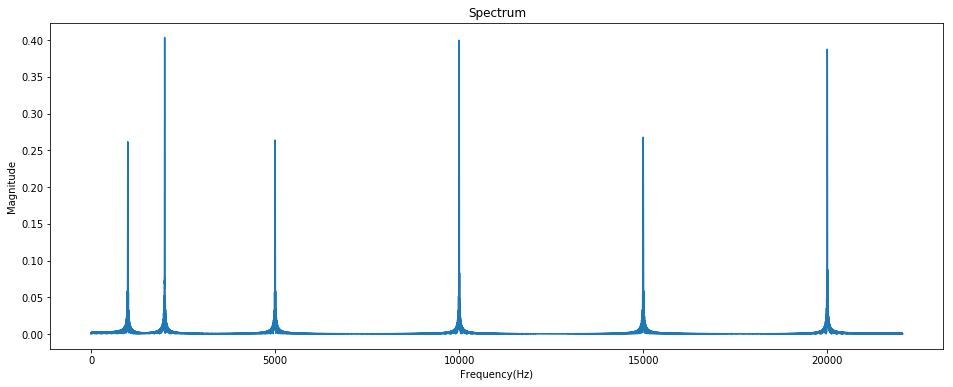

In [7]:
# Frequency axis - max frequency is fs/2 (Nyquist rate)
# n/2 because only need 1-sided spectrum
freqs = (fs/2)*np.linspace(0, 1, len(x_f)//2)
X = compute_fft(x_f)

X_m = np.array(X[0:int(len(x_f)/2)])
# Plot signal in frequency domain
plt.figure(figsize = (16, 6))
plt.plot(freqs, (2/len(x_f))*abs(X_m))
plt.title('Spectrum')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Magnitude')

## 3. STFT and Spectrogram

### a. STFT

$$
\textbf{STFT}\{x[n]\}(m, \omega) \equiv X(m, \omega) = \sum\limits_{n=-\infty}^{\infty}x[n]\omega[n-m]e^{-j\omega n}
$$

In [8]:
# frameSamples must be a 2^n integers - FFT alogirthms
def compute_stft(x, frameSamples, newSamples):
    X = []
    # number of windows
    oneside = int(frameSamples/2) + 1
    k = int((len(x) - frameSamples)/(frameSamples - newSamples))+1
    for i in range(0, k):
        start = i*(frameSamples-newSamples)
        X.append(compute_fft(x[start:start+frameSamples])[0:oneside])
    X = np.array(X).T
    return X/frameSamples

### b. Spectrogram

The magnitude squared of the STFT yields the spectrogram representation of the Power Spectral Density of the function:

$$\text{spectrogram}\{x(t)\}(\tau, \omega) \equiv |X(\tau, \omega)|^2$$

Text(0, 0.5, 'Frequency (Hz)')

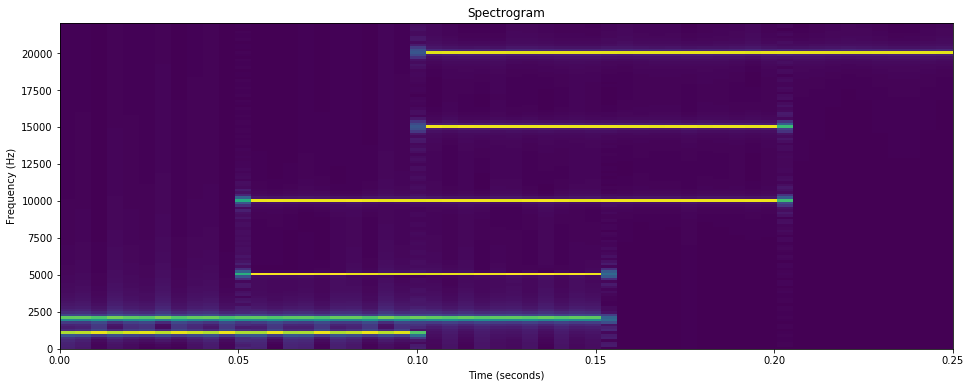

In [9]:
# Plot spectrogram using stft
Y = compute_stft(x, 256, 64)
shapeY = Y.shape
# print(Y.shape)
freqs = np.linspace(0, fs/2, shapeY[0])
# print(len(freqs))
tx = np.linspace(0, len(x)/fs, shapeY[1]) 
plt.figure(figsize = (16, 6))
plt.pcolormesh(tx, freqs, np.abs(Y))
plt.title('Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

## 4. Spectrum analyzer in real-time

Using compute_fft function and compute_stft for creating a spectrum analyzer in realtime

Ref:
- https://github.com/markjay4k/Audio-Spectrum-Analyzer-in-Python
- http://amyboyle.ninja/Pyqtgraph-live-spectrogram

In [2]:
!start python final.py